Complete the exercises below For **Assignment #6**.

Import the following items,
- `pandas as pd`,
- `LinearRegression` from the [`sklearn.linear_model`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model) module,
- `make_column_transformer` from [`sklearn.compose`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.compose),
- `OneHotEncoder` from [`sklearn.preprocessing`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing),
- `make_pipeline` from the [`sklearn.pipeline`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.pipeline) module, and,
- everything from the [plotnine]() package.

In [20]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
import plotnine 
from plotnine import *

## Read in our data for this exercise

Use `pd.read_csv` to read in data from the following URL:
http://bit.ly/2IgDF0E. Capture the data into a dataframe called `df_voles`.

❗️Hint: just like in `R` we can read data directly from a URL.

Preview the data with the `.head()` method.

The data contains the variables:

- `site` for the id of each random study site (each case or row is a survey/trapping site)
- `voles` for the vole count at each site
- `veg` for the percent cover of vegetation at each site
- `soil` identifying a site as “moist” or “dry”

In [15]:
voles_url = 'http://bit.ly/2IgDF0E'
df_voles = pd.read_csv(voles_url)

df_voles.info()
df_voles.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   site    56 non-null     int64 
 1   voles   56 non-null     int64 
 2   veg     56 non-null     int64 
 3   soil    56 non-null     object
dtypes: int64(3), object(1)
memory usage: 1.9+ KB


,site,voles,veg,soil
0,1,17,4,moist
1,2,30,33,moist
2,3,54,94,moist
3,4,49,64,moist
4,5,34,32,moist


## EDA

Let's make a few figures from `df_voles` using `ggplot` from **Plotnine**.

In the cell below plot the `voles` variable (y-axis) versus the `veg` variable and color points by the `soil` variable.

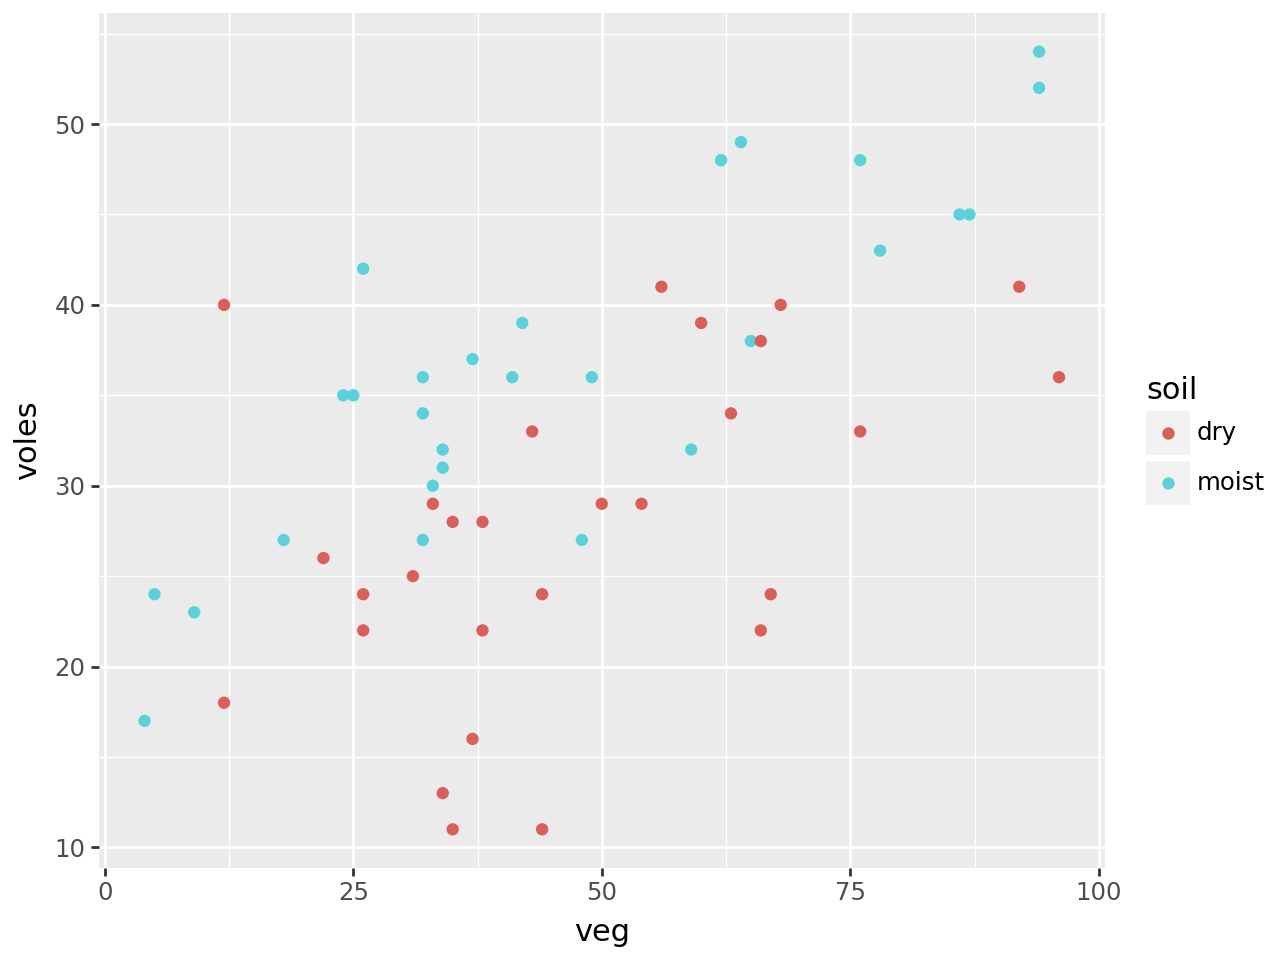

In [3]:
ggplot(df_voles, aes(x='veg', y='voles', color='soil')) \
  + geom_point()

## Modeling

In the cell below, model `voles` with `soil` and `veg` as predictors in a parallel slopes model. 

Here are the steps I would take:
1. Make a column transformer with `make_column_transformer` that transforms `soil` with `OneHotEncoder(drop="first")` and passes 'veg' through untransformed.
2. Create a pipeline with `make_pipeline` using the column transformer from above and `LinearRegression()` as my model. 
3. Get the `X` (training data) and `y` predictor from `df_voles`
4. Use the `.fit()` method for the pipeline to train the model with `X` and `y`. 

In [16]:
# Setup pipeline & model
oh_encoder = OneHotEncoder(drop='first')
transformer = make_column_transformer(
    (oh_encoder, ['soil']),
    ('passthrough', ['veg'])
)
model = make_pipeline(transformer, LinearRegression())

# Train model
X = df_voles.copy()
y = X.pop('voles')
model.fit(X, y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='first'),
                                                  ['soil']),
                                                 ('passthrough', 'passthrough',
                                                  ['veg'])])),
                ('linearregression', LinearRegression())])

Use the function below to get the parameter values for your model from above.

In [8]:
def get_regression_table(pipeline):
    terms=list(pipeline['columntransformer'].get_feature_names_out()) + ['intercept']
    mod = pipeline['linearregression']
    estimates = list(mod.coef_) + [mod.intercept_]
    data = dict(
        term=terms, 
        estimate=estimates,
    )
    return pd.DataFrame(data)

In [17]:
get_regression_table(model)

,term,estimate
0,onehotencoder__soil_moist,9.100298
1,passthrough__veg,0.259069
2,intercept,15.464026


❓Would protecting a site with high vegetation cover be a more effective way to preserve the vole population than a site with low vegetation cover? Why?

(**Hint:** use your chart above to answer. It's also possible to leverage your regression parameters if you chose to model `voles` with a parallel slopes model.)

**Answer:**

In [18]:
df = df_voles.copy()
df['.pred'] = model.predict(df_voles)
df.head()

,site,voles,veg,soil,.pred
0,1,17,4,moist,25.600600
1,2,30,33,moist,33.113599
2,3,54,94,moist,48.916804
3,4,49,64,moist,41.144736
4,5,34,32,moist,32.854530


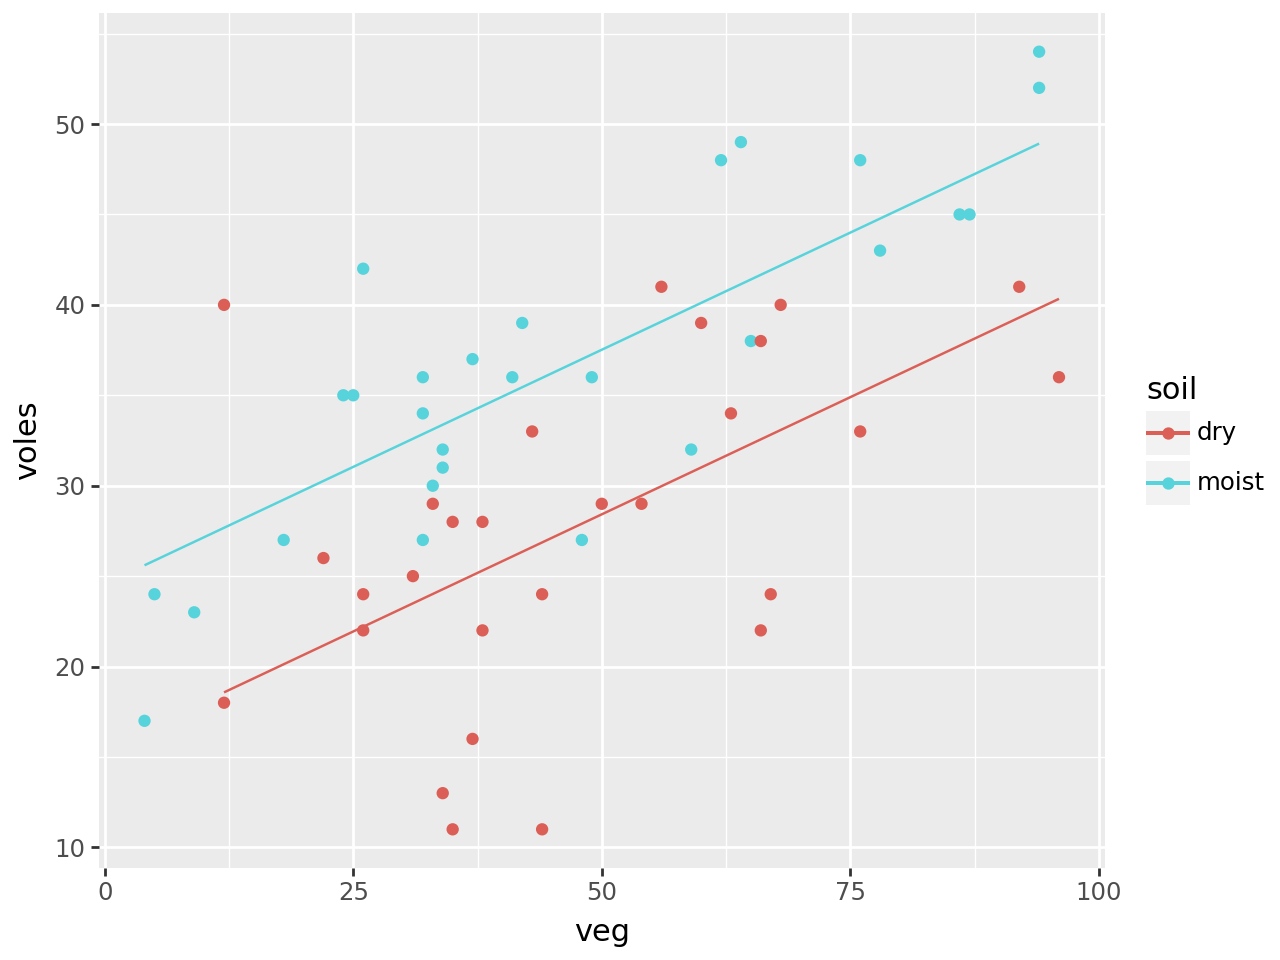

In [19]:
ggplot(df, aes(x='veg', y='voles', color='soil')) + \
  geom_point() + \
  geom_line(aes(x='veg', y='.pred', color='soil'))

> **Matt's Response:**
>
> Generally speaking, yes -- since the `veg` term has a positive slope, we
> expect that increasing vegetation cover would have an associated increase
> in voles, as shown by the `0.259069` positive slope.

❓Dry sites typically cost a lot less to purchase and maintain for conservation organizations. Thus, if a conservation organization decides to purchase a few dry sites, roughly what percent cover of vegetation do they need to maintain on these sites (at a minimum) to support a population of about 30 voles at the site?

(**Hint:** In your chart above, draw a line at voles = 30 using `geom_hline` and make a rough estimate for this answer...)

**Answer:**

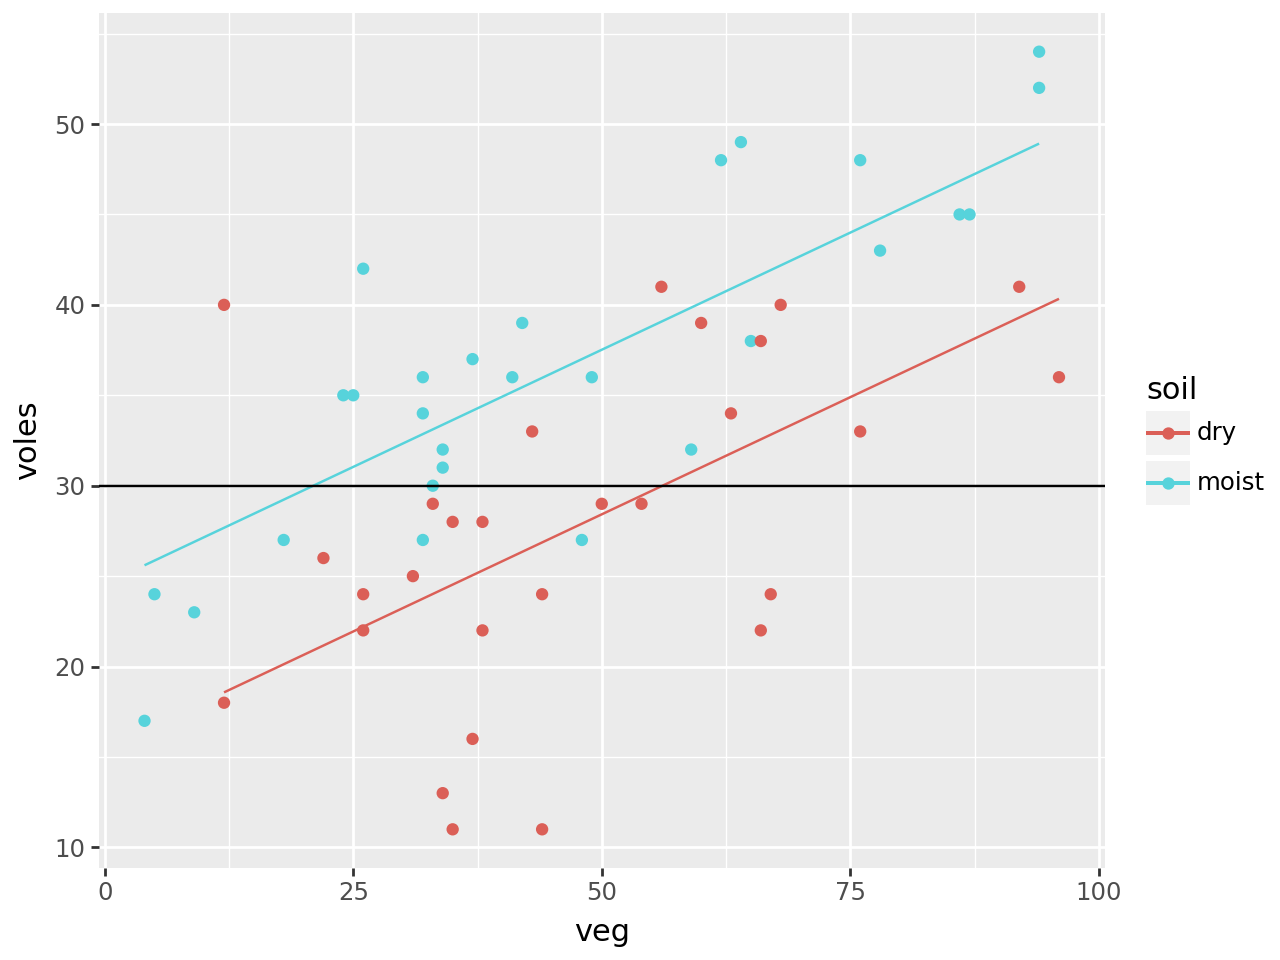

In [21]:
ggplot(df, aes(x='veg', y='voles', color='soil')) + \
  geom_point() + \
  geom_line(aes(x='veg', y='.pred', color='soil')) + \
  geom_hline(yintercept=30)

From the chart, it appears that we would need about 20% coverage with moist
soil and 55% coverage with moist soil. However, I'd like to get an exact
prediction using our estimated parameters.

Solving our prediction equation for $x_{\text{veg}}$:

$$
\begin{align*}
  \hat{y} &=
    b_0 + 
    b_{\text{moist-soil}} \cdot \bf{1}_{\text{moist-soil}} +
    b_{\text{veg}} \cdot x_{\text{veg}}
  \\[6pt]
  x_{\text{veg}} &=
    \frac{
      \hat{y} -
      b_0 -
      b_{\text{moist-soil}} \cdot \bf{1}_{\text{moist-soil}}
    }{ b_{\text{veg}} }
    
\end{align*}
$$

In [22]:
def calculate_veg(target_voles: float, moist_soil: bool) -> float:
    # Coefficients
    b_0 = 15.464026
    b_moist_soil = 9.100298
    b_veg = 0.259069

    return (target_voles - b_0 - int(moist_soil) * b_moist_soil) / b_veg


target_voles = 30
print(f'In order to expect {target_voles:,} voles,',
      'we would need vegetation coverage:')
print('  Moist soil:   ', calculate_veg(target_voles, moist_soil=True))
print('  Dry soil:     ', calculate_veg(target_voles, moist_soil=False))

In order to expect 30 voles, we would need vegetation coverage:
  Moist soil:    20.98157633680602
  Dry soil:      56.1085039120852


> **Matt's Response:**
>
> So, if we want to have 30 voles, we would expect to need about 21%
> vegetation coverage for moist soil. However, if we only have dry soil
> available, we would need about 56% vegetation coverage to expect 30 voles.

❓The Nature Conservancy is looking at purchasing a site for this species (in the same study area) that has moist soil and 40% vegetation cover. Using the regression equation what would you predict as the possible vole population the site might be able to support?

(**Hint:** Use `.predict(pd.DataFrame({"soil": ["moist"], "veg": [40]}))` with yout pipeline.)

**Answer:**

In [23]:
df_input = pd.DataFrame({'soil': ['moist'], 'veg': [40]})
model.predict(df_input)

array([34.92708151])

> **Matt's Response:**
>
> If the Conservancy has moist soil and 40% vegetation cover, we would expect
> about 35 voles at the site.